# PySpark DataFrame 

This notebook is based on https://blog.mattbowers.dev/hello-pyspark

### DataFrame 

It is one of the basic concepts of PySpark. It behaves a little differently from pandas dataframe. 

- Immutability: dataframes are immutable. It means that if you change an object, e.g. by adding a column to a dataframe, PySpark returns a reference to a new dataframe; it does not modify the existing dataframe. This is kind of nice, because we don't have to worry about that whole view versus copy nonsense that happens in pandas.

- Lazy evaluation: means that when we start manipulating a dataframe, PySpark won't actually perform any of the computations until we explicitly ask for the result.

### Create a PySpark session in a Jupyter Notebook
When we launch the pyspark shell, it instantiates an object called spark which is an instance of class pyspark.sql.session.SparkSession. It is entry point for all kinds of PySpark functionality.

In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('My Spark App').getOrCreate()

In [2]:
import pandas as pd

# load tips dataset into a pandas dataframe
pandas_df = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv')

# create pyspark dataframe from a pandas dataframe
pyspark_df = spark.createDataFrame(pandas_df)

In [3]:
# show the first few rows of the dataframe
pyspark_df.show(3)

+----------+----+------+------+---+------+----+
|total_bill| tip|   sex|smoker|day|  time|size|
+----------+----+------+------+---+------+----+
|     16.99|1.01|Female|    No|Sun|Dinner|   2|
|     10.34|1.66|  Male|    No|Sun|Dinner|   3|
|     21.01| 3.5|  Male|    No|Sun|Dinner|   3|
+----------+----+------+------+---+------+----+
only showing top 3 rows



In [4]:
# show the dataframe schema
pyspark_df.printSchema()

root
 |-- total_bill: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: long (nullable = true)



In [5]:
# select some columns
pyspark_df.select('total_bill', 'tip')

DataFrame[total_bill: double, tip: double]

In [6]:
# compare a column to a value
pyspark_df.filter('total_bill > 20')

# check equality with any of several possible values
pyspark_df.filter('day in ("Sat", "Sun")')

# use "and" 
pyspark_df.filter('day == "Fri" and time == "Lunch"')

DataFrame[total_bill: double, tip: double, sex: string, smoker: string, day: string, time: string, size: bigint]

In [7]:
# add a new column using col() to reference other columns
import pyspark.sql.functions as f

pyspark_df.withColumn('tip_percent', f.col('tip')/f.col('total_bill'))

DataFrame[total_bill: double, tip: double, sex: string, smoker: string, day: string, time: string, size: bigint, tip_percent: double]

In [9]:
# conditional assignment (like CASE WHEN)
pyspark_df.withColumn('is_male', f.when(f.col('sex') == 'Male', True).otherwise(False))

# using multiple when conditions and values
pyspark_df.withColumn('bill_size', 
    f.when(f.col('total_bill') < 10, 'small')
    .when(f.col('total_bill') < 20, 'medium')
    .otherwise('large')
)

DataFrame[total_bill: double, tip: double, sex: string, smoker: string, day: string, time: string, size: bigint, bill_size: string]

In [10]:
# group by and count
pyspark_df.groupBy('time').count().show()

# group by and specify column-aggregation mapping with agg()
pyspark_df.groupBy('time').agg({'total_bill': 'mean', 'tip': 'max'}).show()

+------+-----+
|  time|count|
+------+-----+
| Lunch|   68|
|Dinner|  176|
+------+-----+

+------+--------+------------------+
|  time|max(tip)|   avg(total_bill)|
+------+--------+------------------+
| Lunch|     6.7|17.168676470588235|
|Dinner|    10.0| 20.79715909090909|
+------+--------+------------------+



+----------+----+------+------+---+------+----+
|total_bill| tip|   sex|smoker|day|  time|size|
+----------+----+------+------+---+------+----+
|     16.99|1.01|Female|    No|Sun|Dinner|   2|
|     10.34|1.66|  Male|    No|Sun|Dinner|   3|
|     21.01| 3.5|  Male|    No|Sun|Dinner|   3|
|     23.68|3.31|  Male|    No|Sun|Dinner|   2|
|     24.59|3.61|Female|    No|Sun|Dinner|   4|
+----------+----+------+------+---+------+----+
only showing top 5 rows

+------+---+------------------+-------+-------------------+
|  time|  n|           avg_tip|med_tip|       pct_tip_gt_3|
+------+---+------------------+-------+-------------------+
| Lunch| 68|2.7280882352941176|    2.2|0.27941176470588236|
|Dinner|176| 3.102670454545455|    3.0|0.44886363636363635|
+------+---+------------------+-------+-------------------+



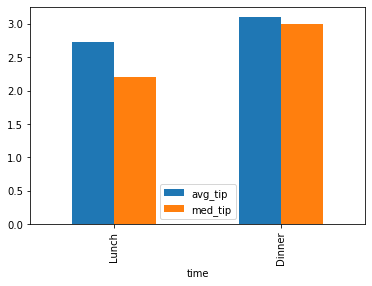

In [13]:
# put pyspark dataframe in SQL world and query it
pyspark_df.createOrReplaceTempView('tips')
spark.sql('select * from tips').show(5)

# run hive query and save result to dataframe
tip_stats_by_time = spark.sql("""
    select
        time
        , count(*) as n 
        , avg(tip) as avg_tip
        , percentile_approx(tip, 0.5) as med_tip
        , avg(case when tip > 3 then 1 else 0 end) as pct_tip_gt_3
    from 
        tips
    group by 1
""")

tip_stats_by_time.show()

# read aggregated pyspark dataframe into pandas for plotting
plot_pdf = tip_stats_by_time.toPandas()
plot_pdf.plot.bar(x='time', y=['avg_tip', 'med_tip']);